In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use("asludds")
from tqdm import tqdm

In [2]:
# High level parameters

#### DESIGN 1 ####
# propagation_loss_dB_m = 68.8
# Ring1_radius = 40e-6
# Ring2_radius = 1.05 * Ring1_radius
# highest_loss_allowed_dB = -0.6
# vernier_delta_FSR_over_FWHM_bound = 1.5
# longitudinal_delta_FSR_over_FWHM_bound = 0.735
# estimated_kappa_4mm = 0.06
# estimated_kappa_5mm = 0.056
# estimated_kappa_6mm = 0.056

#### DESIGN 2 ####
# propagation_loss_dB_m = 68.8
# Ring1_radius = 60e-6
# Ring2_radius = 1.05 * Ring1_radius
# highest_loss_allowed_dB = -0.6
# vernier_delta_FSR_over_FWHM_bound = 1.5
# longitudinal_delta_FSR_over_FWHM_bound = 0.735
# estimated_kappa_4mm = 0.09
# estimated_kappa_5mm = 0.084
# estimated_kappa_6mm = 0.084


#### DESIGN 3 ####
propagation_loss_dB_m = 68.8
Ring1_radius = 60e-6
Ring2_radius = 1.025 * Ring1_radius
highest_loss_allowed_dB = -0.8
vernier_delta_FSR_over_FWHM_bound = 1.16
longitudinal_delta_FSR_over_FWHM_bound = 0.735
estimated_kappa_4mm = 0.063
estimated_kappa_5mm = 0.063
estimated_kappa_6mm = 0.063

Vernier FSR is 91.96154809427736 (nm)
Vernier FSR is 91.96154809427736 (nm)
Vernier FSR is 91.96154809427736 (nm)


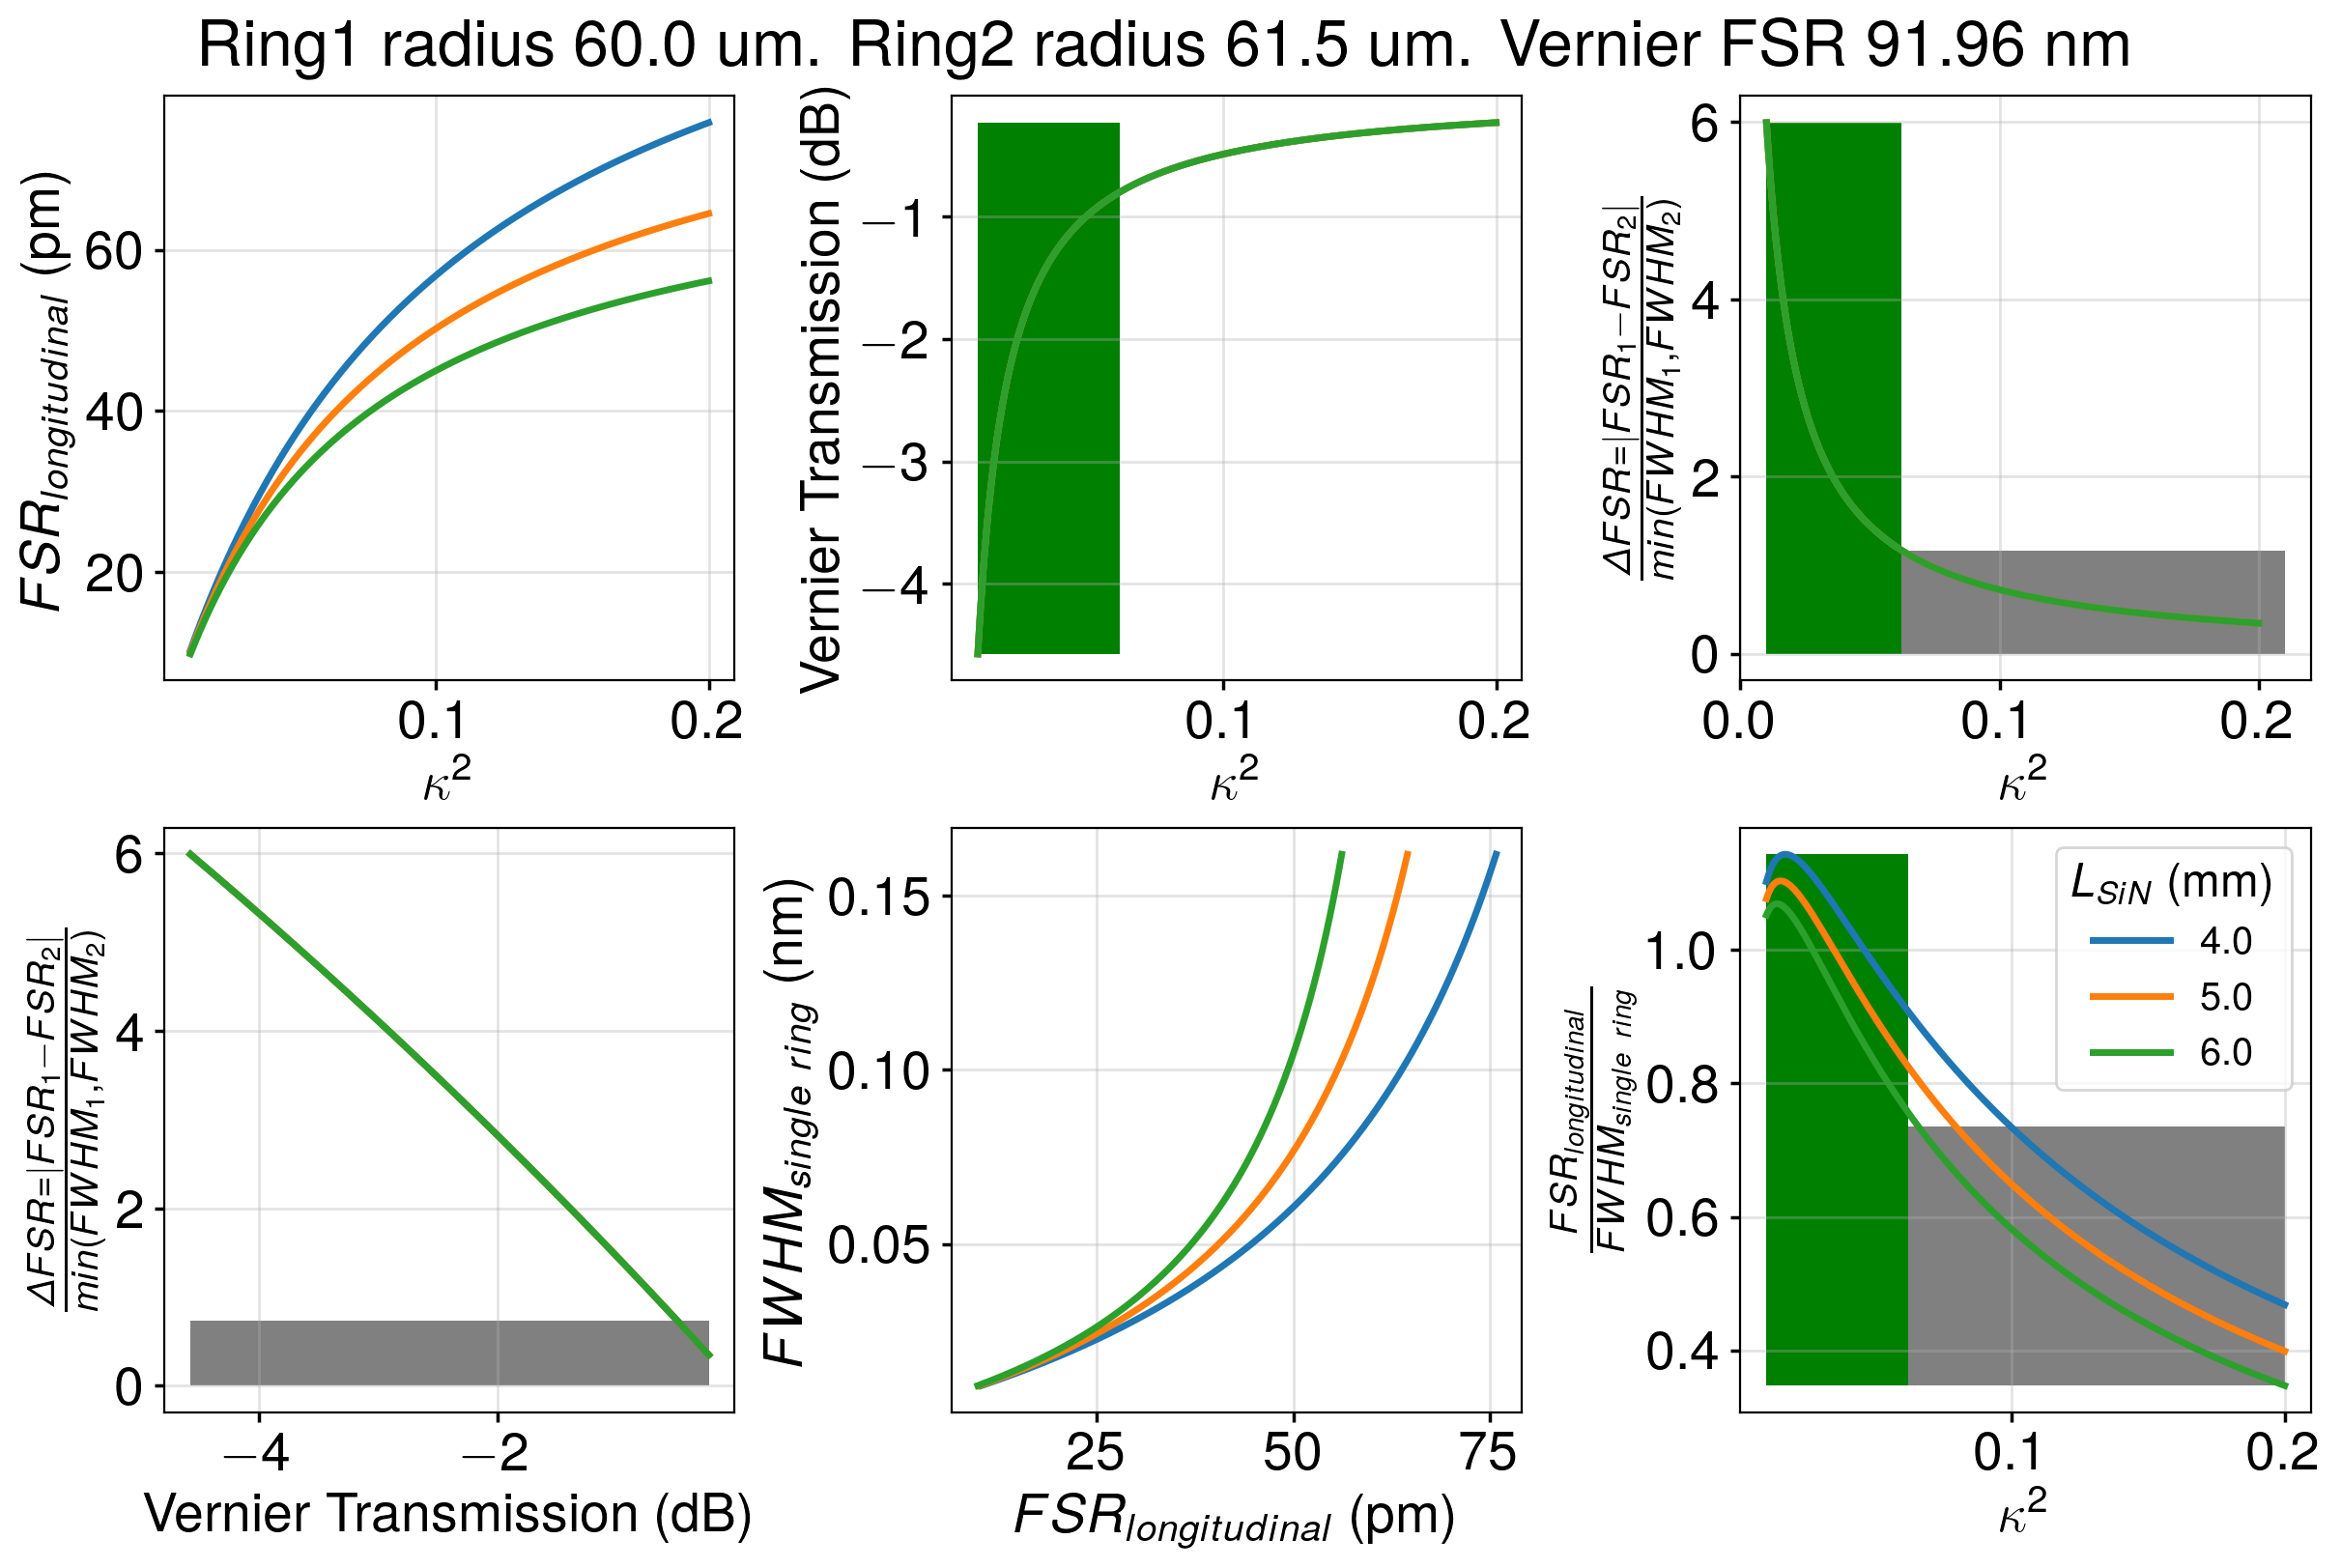

Kappa squared loss barrier:  0.062112112112112115


In [7]:
class SiN_add_drop_ring_resonator():
    def __init__(self,kappa_squared,radius,propagation_loss_dB_m=600000): #Propagation loss value should be written in the above cell, don't write it here
        self.kappa = np.sqrt(kappa_squared)
        self.r = np.sqrt(1-kappa_squared)
        self.radius = radius
        self.propagation_loss_dB_m = propagation_loss_dB_m
        self.Lrt = 2*np.pi * self.radius
        self.ng = 1.98
        self.a = np.exp(-self.propagation_loss_dB_m/(2*4.34) * self.Lrt)
        self.Lambda_res = 1310e-9

    def transmission(self,phi=0):
        # Calculates transmission through ring. Assumes on resonance by default
        num = (1-self.r**2)*(1-self.r**2)*self.a
        denom = 1 - 2 * self.r**2 * self.a * np.cos(phi) + (self.r**2 * self.a)**2
        return num/denom
    
    def Q(self):
        # The loaded quality factor for an add-drop ring resonator
        num = np.pi * self.ng * self.Lrt * np.sqrt(self.r**2 *self.a)
        denom = self.Lambda_res * (1 - self.r**2 * self.a)
        return num/denom
    
    def FSR(self):
        return self.Lambda_res**2/(self.ng * self.Lrt)
    
    def FWHM(self):
        return self.Lambda_res/self.Q()
    
    def Finesse(self):
        return self.FSR()/self.FWHM()
    
    def wavelength_sweep(self,lambda_start=1308e-9,lambda_stop=1312e-9,num=1000):
        lambda_sweep = np.linspace(lambda_start,lambda_stop,num=num)
        phase_sweep = 2*np.pi * (lambda_sweep - self.Lambda_res)/self.FSR()
        transmission_storage = [self.transmission(phi=i) for i in phase_sweep]
        return lambda_sweep, np.array(transmission_storage)
    
class Vernier_rings_in_longitudinal_cavity():
    def __init__(self,L_long,kappa_squared,radius1,radius2,propagation_loss_dB_m=600000):
        self.ring1 = SiN_add_drop_ring_resonator(kappa_squared,radius1,propagation_loss_dB_m)
        self.ring2 = SiN_add_drop_ring_resonator(kappa_squared,radius2,propagation_loss_dB_m)
        self.L_long = L_long

    def transmission_through_vernier(self):
        return self.ring1.transmission() * self.ring2.transmission()
    
    def Lrt_eff(self):
        return 2*self.L_long + (0.5 + (1 - self.ring1.kappa**2)/(self.ring1.kappa**2))* self.ring1.Lrt + (0.5 + (1 - self.ring2.kappa**2)/(self.ring2.kappa**2))* self.ring2.Lrt
    
    def FSR_longitudinal(self):
        return self.ring1.Lambda_res**2/(self.ring1.ng * self.Lrt_eff())
    
    def Vernier_FSR(self):
        return self.ring1.FSR()*self.ring2.FSR()/abs(self.ring1.FSR() - self.ring2.FSR())
    
    def Vernier_wavelength_sweep(self,lambda_start=1308e-9,lambda_stop=1312e-9,num=1000):
        wavelengths, ring1_sweep = self.ring1.wavelength_sweep(lambda_start=lambda_start,lambda_stop=lambda_stop,num=num)
        wavelengths, ring2_sweep = self.ring2.wavelength_sweep(lambda_start=lambda_start,lambda_stop=lambda_stop,num=num)
        return wavelengths, ring1_sweep * ring2_sweep
    
    def longitudinal_cavity_transmission(self, Lambda):
        R1 = 0.9 #Values are placeholders. The Q of this fabry-perot cavity doesn't matter for calculating SMSR
        R2 = 0.9
        T1 = 1 - R1
        T2 = 1 - R2
        length_of_longitudinal_cavity = self.Lrt_eff()/2 #Factor of two because the function calculates the round trip length
        phi_offset = 2*np.pi*self.ring1.ng*length_of_longitudinal_cavity/self.ring1.Lambda_res #Subtract a phase offset to have fabry-perot cavity on resonance at 1310nm
        phi = 2 * np.pi * self.ring1.ng * length_of_longitudinal_cavity/ Lambda - phi_offset
        num = -1 * np.sqrt(T1*T2) *  np.exp(-1j * phi)
        denom = 1 - np.sqrt(R1*R2) * np.exp(-2 * 1j * phi)
        H = num/denom
        return np.real(H * np.conj(H))

    def Vernier_with_longitudinal_wavelength_sweep(self,lambda_start=1308e-9,lambda_stop=1312e-9,num=1000):
        wavelengths, ring1_sweep = self.ring1.wavelength_sweep(lambda_start=lambda_start,lambda_stop=lambda_stop,num=num)
        wavelengths, ring2_sweep = self.ring2.wavelength_sweep(lambda_start=lambda_start,lambda_stop=lambda_stop,num=num)
        long_cavity_sweep = np.array([self.longitudinal_cavity_transmission(i) for i in wavelengths])
        return wavelengths, ring1_sweep * ring2_sweep * long_cavity_sweep
    
    def Vernier_SMSR(self):
        wav1 = self.ring1.Lambda_res - self.ring1.FSR()
        wav2 = self.ring2.Lambda_res - self.ring2.FSR()
        wav,amp = self.Vernier_wavelength_sweep(
            lambda_start=self.ring1.Lambda_res - 1.5*max(self.ring1.FSR(),self.ring2.FSR()),
            lambda_stop=self.ring1.Lambda_res + 1.5*max(self.ring1.FSR(),self.ring2.FSR()),
            num=100000
        )
        wav1_index = np.argmin(np.abs(wav - wav1))
        wav2_index = np.argmin(np.abs(wav - wav2))
        resonant_index = np.argmin(np.abs(wav - self.ring1.Lambda_res))
        return amp[resonant_index]/max(amp[wav1_index],amp[wav2_index])
    
    def Longitudinal_SMSR(self):
        wav1 = self.ring1.Lambda_res - self.FSR_longitudinal()
        wav,amp = self.Vernier_with_longitudinal_wavelength_sweep(
            lambda_start=self.ring1.Lambda_res - 1.5*self.FSR_longitudinal(),
            lambda_stop=self.ring1.Lambda_res + 1.5*self.FSR_longitudinal(),
            num=500000
        )
        wav1_index = np.argmin(np.abs(wav - wav1))
        resonant_index = np.argmin(np.abs(wav - self.ring1.Lambda_res))
        return amp[resonant_index]/amp[wav1_index]

    
L_long_sweep = np.array([4e-3,5e-3,6e-3])
kappa_squared_sweep = np.linspace(0.01,0.2,num=1000)
fig,axs = plt.subplots(nrows=2,ncols=3,figsize=(12,8))
for L_long in L_long_sweep:
    transmission_storage = []
    FSR_storage = []
    min_ring_FWHM_storage = []
    delta_ring_FSR_storage = []
    for kappa_squared in kappa_squared_sweep:
        tmp = Vernier_rings_in_longitudinal_cavity(L_long,kappa_squared,Ring1_radius,Ring2_radius,propagation_loss_dB_m=propagation_loss_dB_m)
        transmission_storage.append(tmp.transmission_through_vernier())
        FSR_storage.append(tmp.FSR_longitudinal())
        min_ring_FWHM_storage.append(min(tmp.ring1.FWHM(),tmp.ring2.FWHM()))
        delta_ring_FSR_storage.append(abs(tmp.ring1.FSR() - tmp.ring2.FSR()))

    print(f"Vernier FSR is {tmp.Vernier_FSR()*1e9} (nm)")
    kappa_highest_loss_allowed_index = np.argmin(np.abs(10*np.log10(transmission_storage) - highest_loss_allowed_dB))

    transmission_storage = np.array(transmission_storage)
    FSR_storage = np.array(FSR_storage)
    min_ring_FWHM_storage = np.array(min_ring_FWHM_storage)
    delta_ring_FSR_storage = np.array(delta_ring_FSR_storage)
    
    axs[0,0].plot(kappa_squared_sweep,FSR_storage*1e12)

    axs[0,1].plot(kappa_squared_sweep,10*np.log10(transmission_storage))
    axs[0,1].add_patch(matplotlib.patches.Rectangle(
        xy = (min(kappa_squared_sweep),min(10*np.log10(transmission_storage))),
        width = kappa_squared_sweep[kappa_highest_loss_allowed_index] - min(kappa_squared_sweep), 
        height = max(10*np.log10(transmission_storage)) - min(10*np.log10(transmission_storage)),
        facecolor="green",
        label='_nolegend_'))
    
    axs[0,2].plot(kappa_squared_sweep,delta_ring_FSR_storage/min_ring_FWHM_storage)
    axs[0,2].add_patch(matplotlib.patches.Rectangle((min(kappa_squared_sweep),0), max(kappa_squared_sweep), vernier_delta_FSR_over_FWHM_bound, facecolor="grey",label='_nolegend_'))
    axs[0,2].add_patch(matplotlib.patches.Rectangle(
        xy = (min(kappa_squared_sweep),0),
        width = kappa_squared_sweep[kappa_highest_loss_allowed_index] - min(kappa_squared_sweep), 
        height = max(delta_ring_FSR_storage/min_ring_FWHM_storage),
        facecolor="green",
        label='_nolegend_'))


    axs[1,0].plot(10*np.log10(transmission_storage),delta_ring_FSR_storage/min_ring_FWHM_storage)
    axs[1,0].add_patch(matplotlib.patches.Rectangle((min(10*np.log10(transmission_storage)),0), max(10*np.log10(transmission_storage)) - min(10*np.log10(transmission_storage)), longitudinal_delta_FSR_over_FWHM_bound, facecolor="grey",label='_nolegend_'))
    axs[1,1].plot(FSR_storage*1e12,min_ring_FWHM_storage*1e9)

    axs[1,2].plot(kappa_squared_sweep,FSR_storage/min_ring_FWHM_storage)
    axs[1,2].add_patch(matplotlib.patches.Rectangle((min(kappa_squared_sweep),min(FSR_storage/min_ring_FWHM_storage)), max(kappa_squared_sweep) - min(kappa_squared_sweep), longitudinal_delta_FSR_over_FWHM_bound - min(FSR_storage/min_ring_FWHM_storage), facecolor="grey",label='_nolegend_'))
    axs[1,2].add_patch(matplotlib.patches.Rectangle(
        xy = (min(kappa_squared_sweep),min(FSR_storage/min_ring_FWHM_storage)),
        width = kappa_squared_sweep[kappa_highest_loss_allowed_index] - min(kappa_squared_sweep), 
        height = max(FSR_storage/min_ring_FWHM_storage) - min(FSR_storage/min_ring_FWHM_storage),
        facecolor="green",
        label='_nolegend_'))

axs[0,0].set_xlabel(r"$\kappa^{2}$")
axs[0,0].set_ylabel(r"$FSR_{longitudinal}$ (pm)")

axs[0,1].set_xlabel(r"$\kappa^{2}$")
axs[0,1].set_ylabel("Vernier Transmission (dB)")

axs[0,2].set_xlabel(r"$\kappa^{2}$")
axs[0,2].set_ylabel(r"$\frac{\Delta FSR = |FSR_{1} - FSR_{2}|}{min(FWHM_{1},FWHM_{2})}$")

axs[1,0].set_xlabel("Vernier Transmission (dB)")
axs[1,0].set_ylabel(r"$\frac{\Delta FSR = |FSR_{1} - FSR_{2}|}{min(FWHM_{1},FWHM_{2})}$")

axs[1,1].set_xlabel(r"$FSR_{longitudinal}$ (pm)")
axs[1,1].set_ylabel(r"$FWHM_{single \ ring}$ (nm)")

axs[1,2].set_xlabel(r"$\kappa^{2}$")
axs[1,2].set_ylabel(r"$\frac{FSR_{longitudinal}}{FWHM_{single \ ring}}$")
axs[1,2].legend(L_long_sweep*1e3,title=r'$L_{SiN}$ (mm)')

# axs[1,2].set_xlim(0.06,0.07)
# axs[0,2].set_xlim(0.06,0.07)
# axs[0,1].set_ylim(-1,0)

plt.suptitle(f"Ring1 radius {round(Ring1_radius*1e6,2)} um. Ring2 radius {round(Ring2_radius*1e6,2)} um. Vernier FSR {round(tmp.Vernier_FSR()*1e9,2)} nm")
plt.show()

print("Kappa squared loss barrier: ", kappa_squared_sweep[kappa_highest_loss_allowed_index])

# 4mm Longitudinal Vernier Ring Mirror design

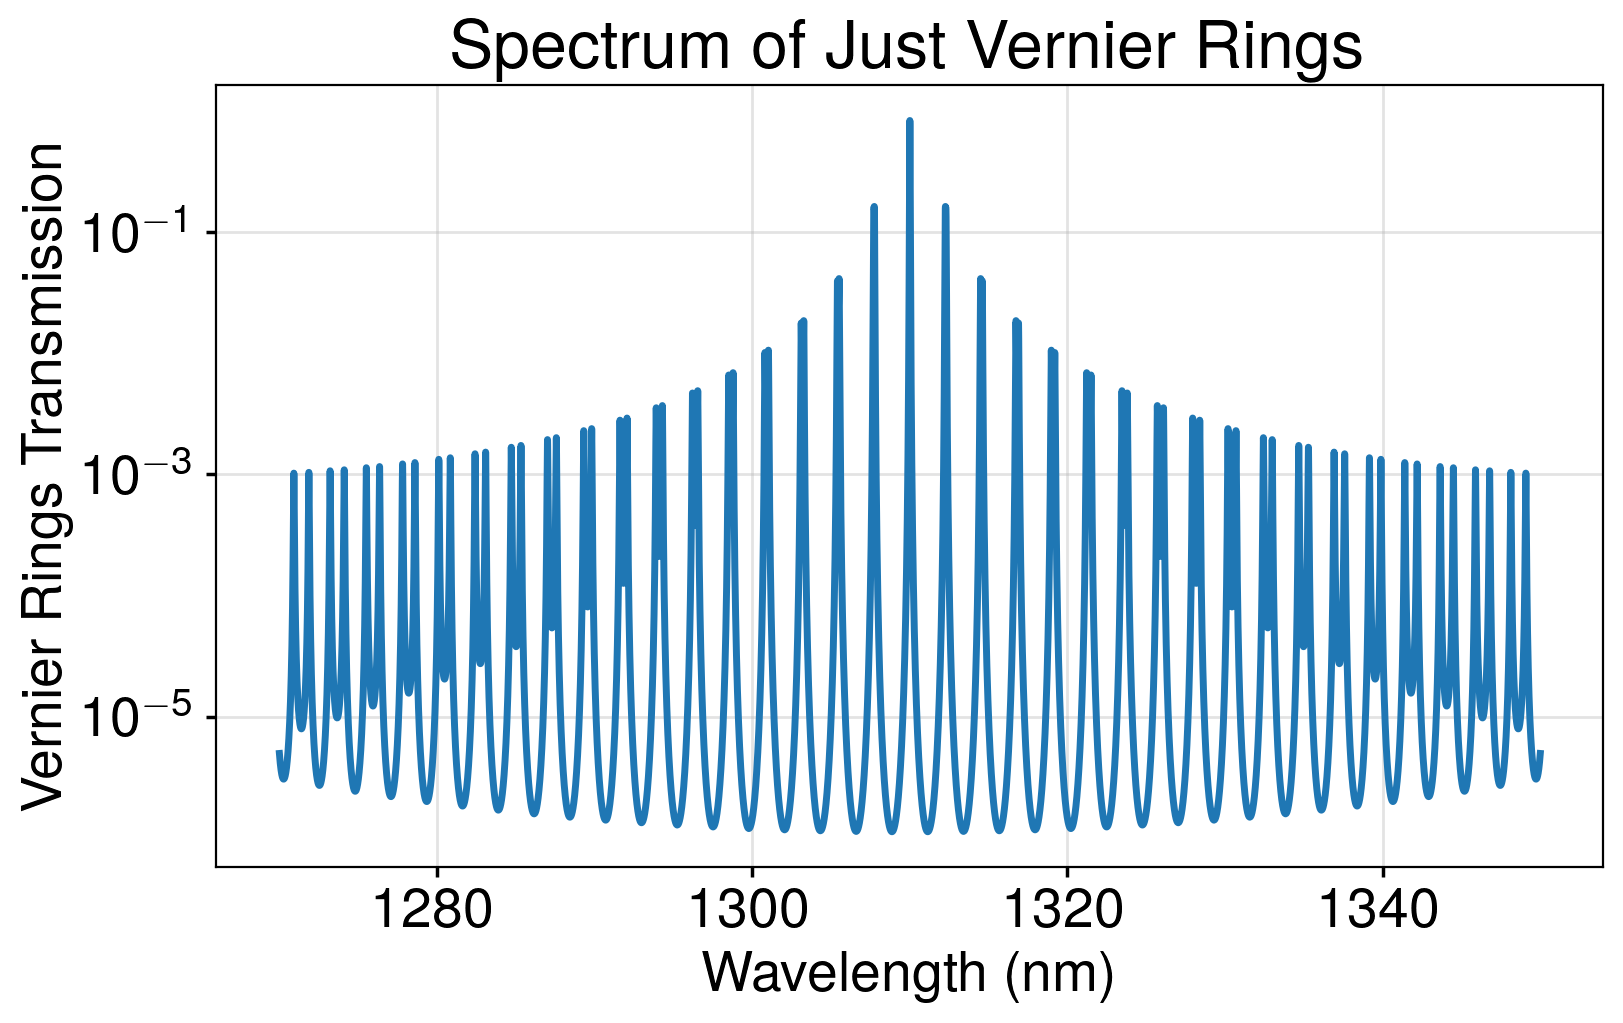

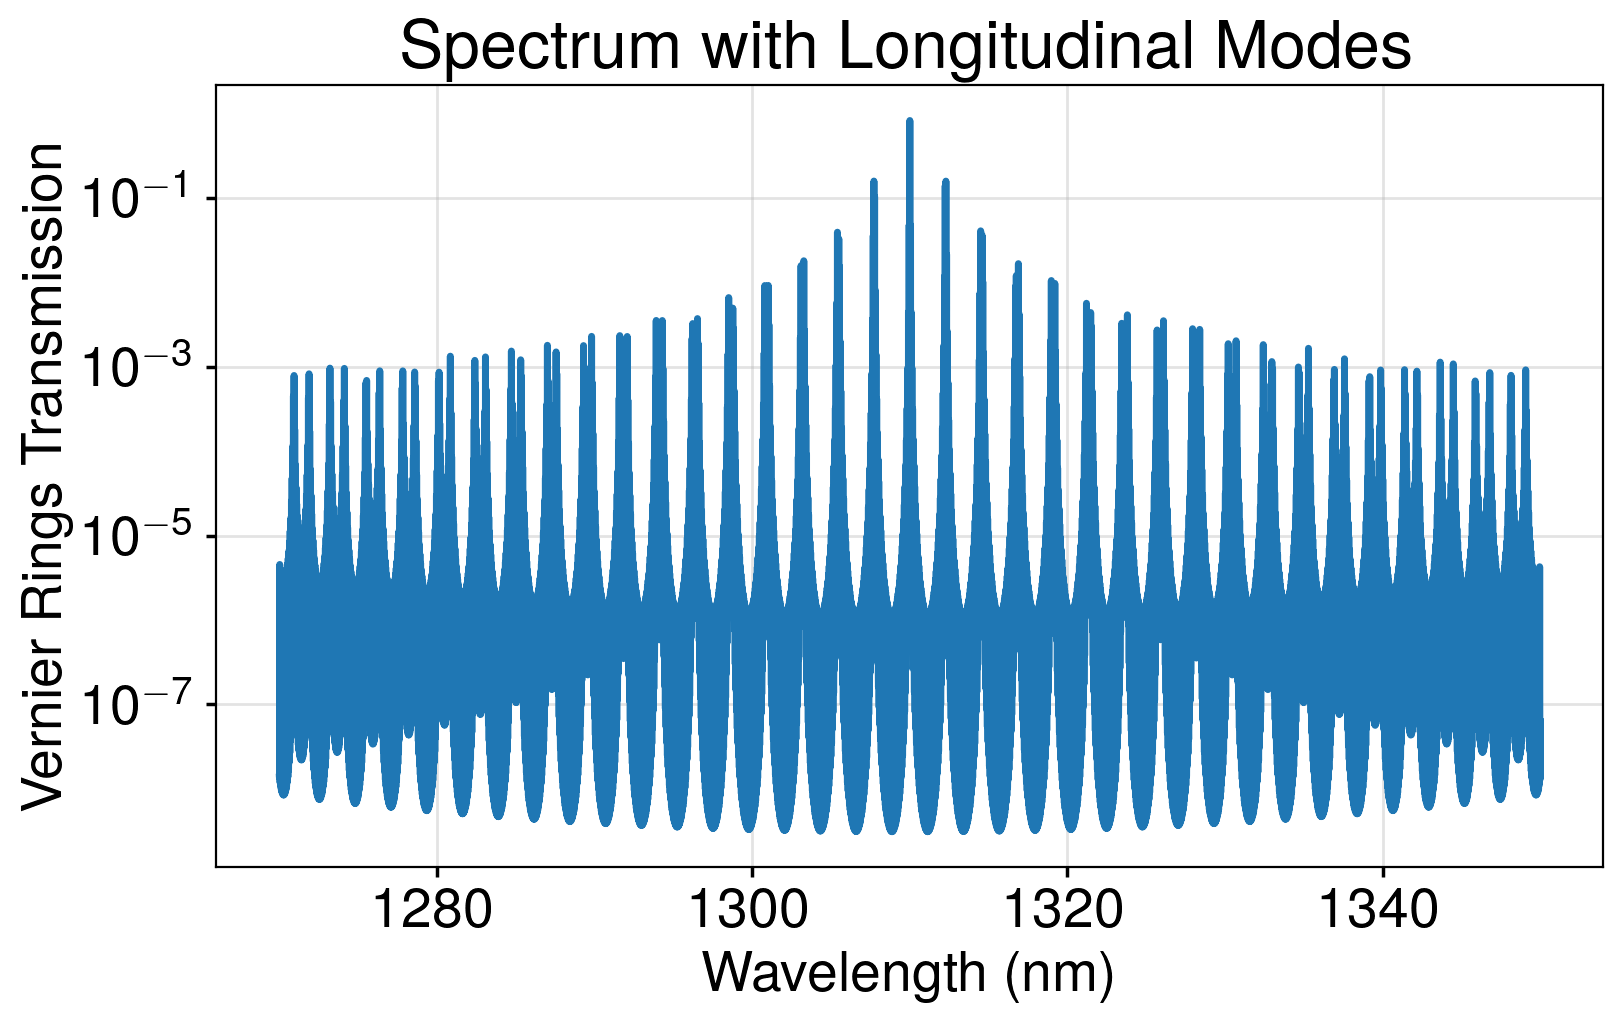

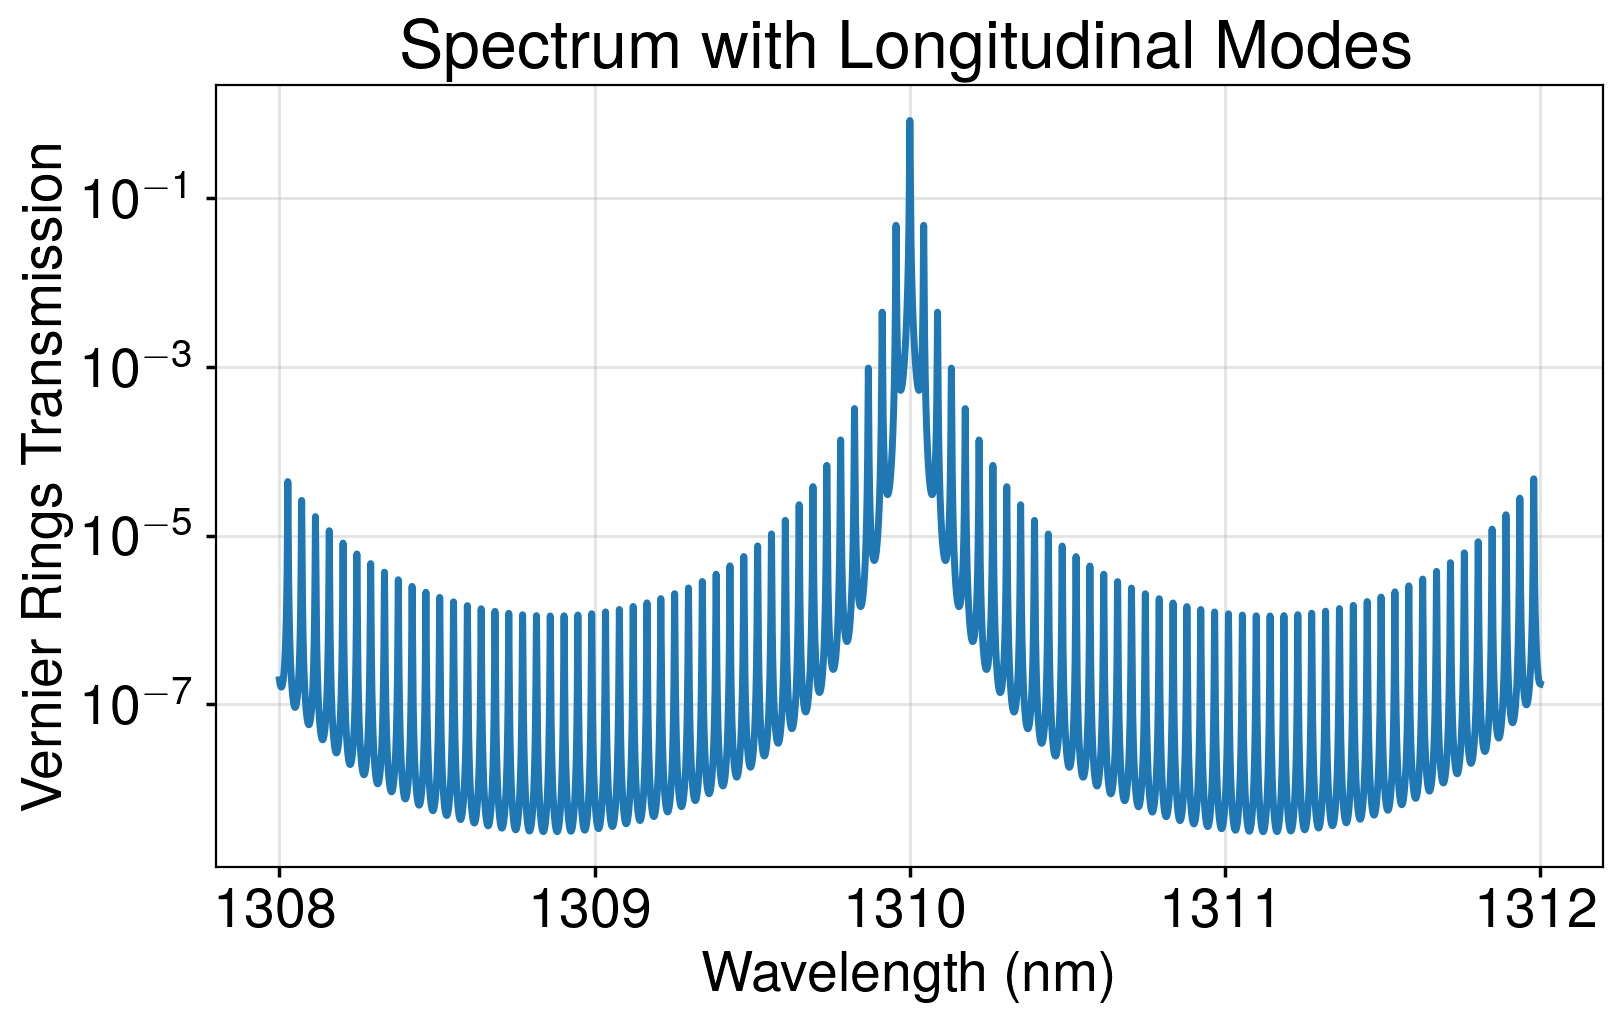

Loss in dB:  -0.7898937350084299
Ring Q:  26296.521176761948
Ring FWHM:  4.9816475388297285e-11
Ring FSR:  2.2990387023569154e-09
Ring Finesse:  46.15016787994194
Vernier SMSR (dB):  7.827817500918704
Longitudinal SMSR (dB):  12.421590269185003


In [4]:
tmp = Vernier_rings_in_longitudinal_cavity(L_long=4e-3,kappa_squared=estimated_kappa_4mm,radius1=Ring1_radius,radius2=Ring2_radius,propagation_loss_dB_m=propagation_loss_dB_m)
num_points = 500000
wav, amp = tmp.Vernier_wavelength_sweep(lambda_start=1270e-9,lambda_stop=1350e-9,num=num_points)


plt.figure()
plt.semilogy(wav*1e9,amp)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Vernier Rings Transmission")
plt.title("Spectrum of Just Vernier Rings")
plt.show()

wav, amp = tmp.Vernier_with_longitudinal_wavelength_sweep(lambda_start=1270e-9,lambda_stop=1350e-9,num=num_points)
plt.figure()
plt.semilogy(wav*1e9,amp)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Vernier Rings Transmission")
plt.title("Spectrum with Longitudinal Modes")
plt.show()

wav, amp = tmp.Vernier_with_longitudinal_wavelength_sweep(lambda_start=1308e-9,lambda_stop=1312e-9,num=num_points)
plt.figure()
plt.semilogy(wav*1e9,amp)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Vernier Rings Transmission")
plt.title("Spectrum with Longitudinal Modes")
plt.show()

print("Loss in dB: ", 10*np.log10(np.max(amp)))

print("Ring Q: ",tmp.ring1.Q())
print("Ring FWHM: ",tmp.ring1.FWHM())
print("Ring FSR: ",tmp.ring1.FSR())
print("Ring Finesse: ",tmp.ring1.Finesse())
print("Vernier SMSR (dB): ", 10*np.log10(tmp.Vernier_SMSR()))
print("Longitudinal SMSR (dB): ", 10*np.log10(tmp.Longitudinal_SMSR()))


# 5mm Longitudinal Vernier Ring Mirror design

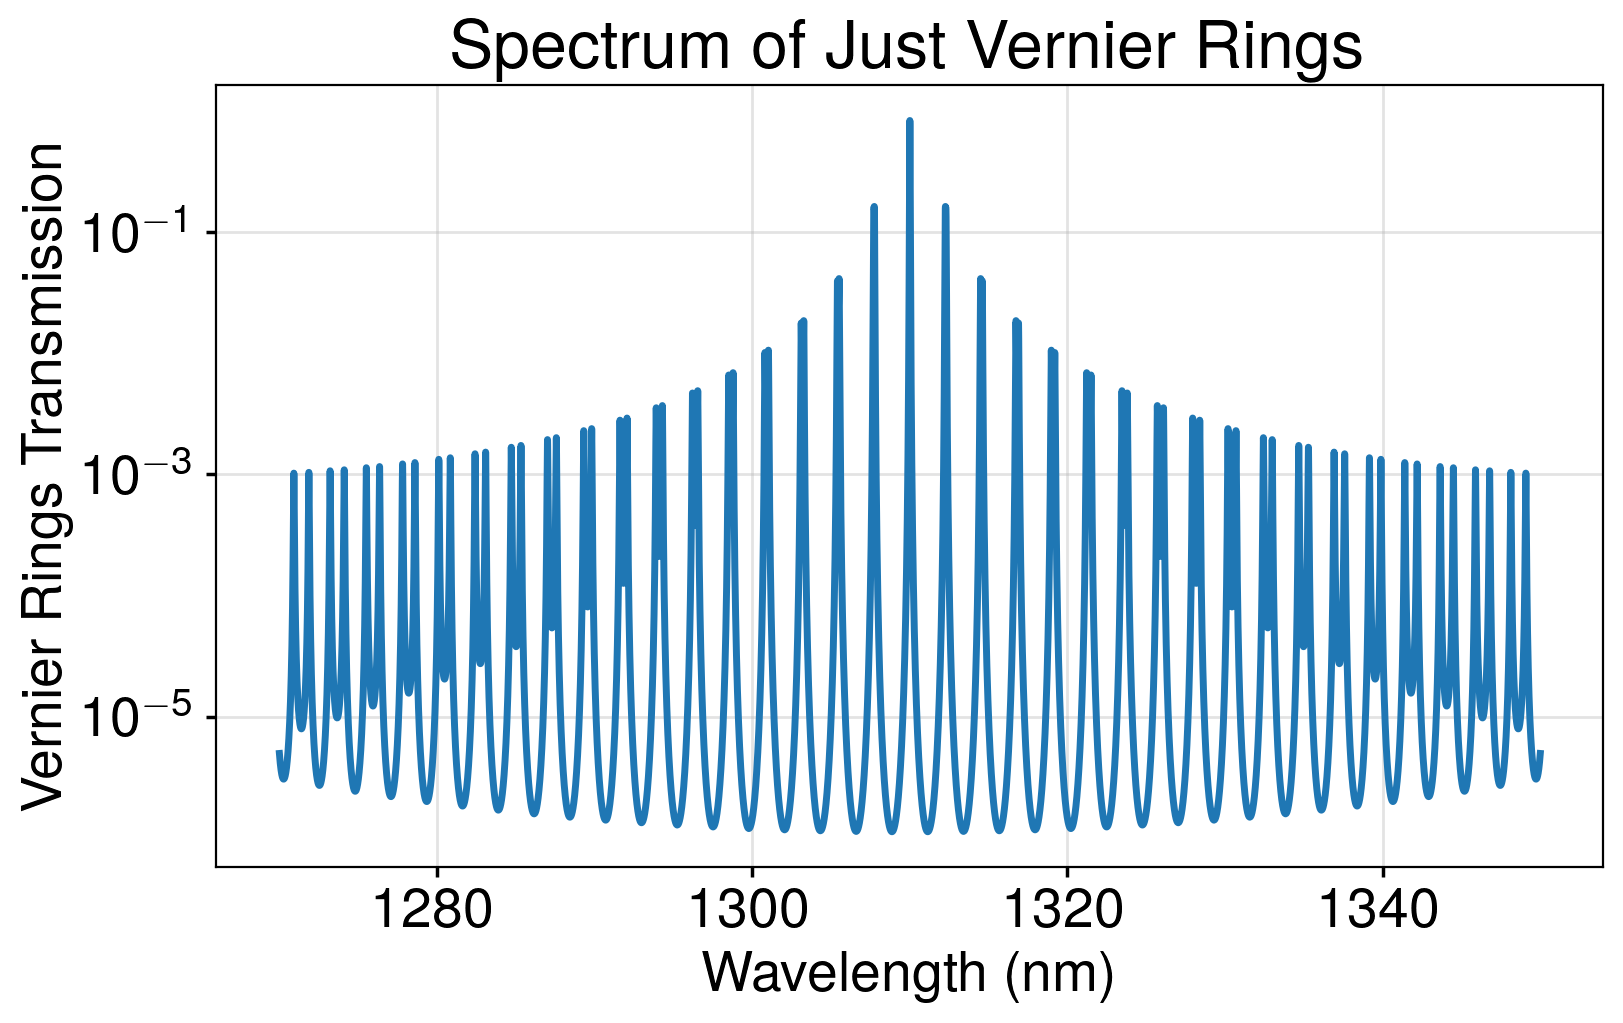

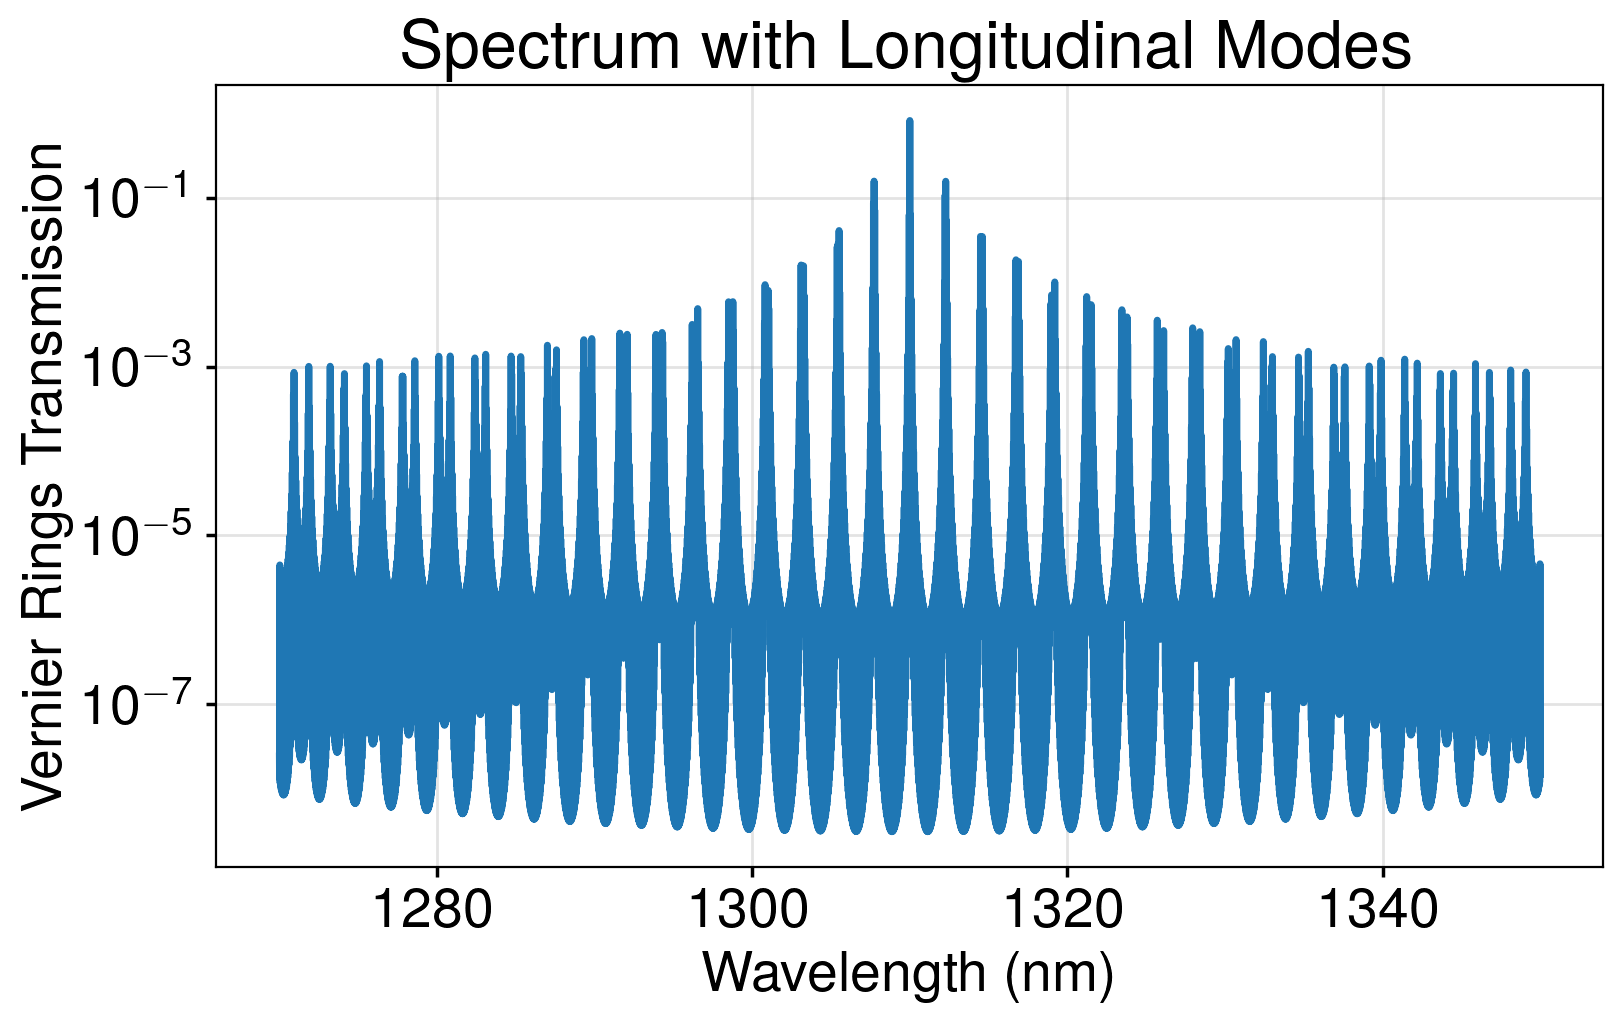

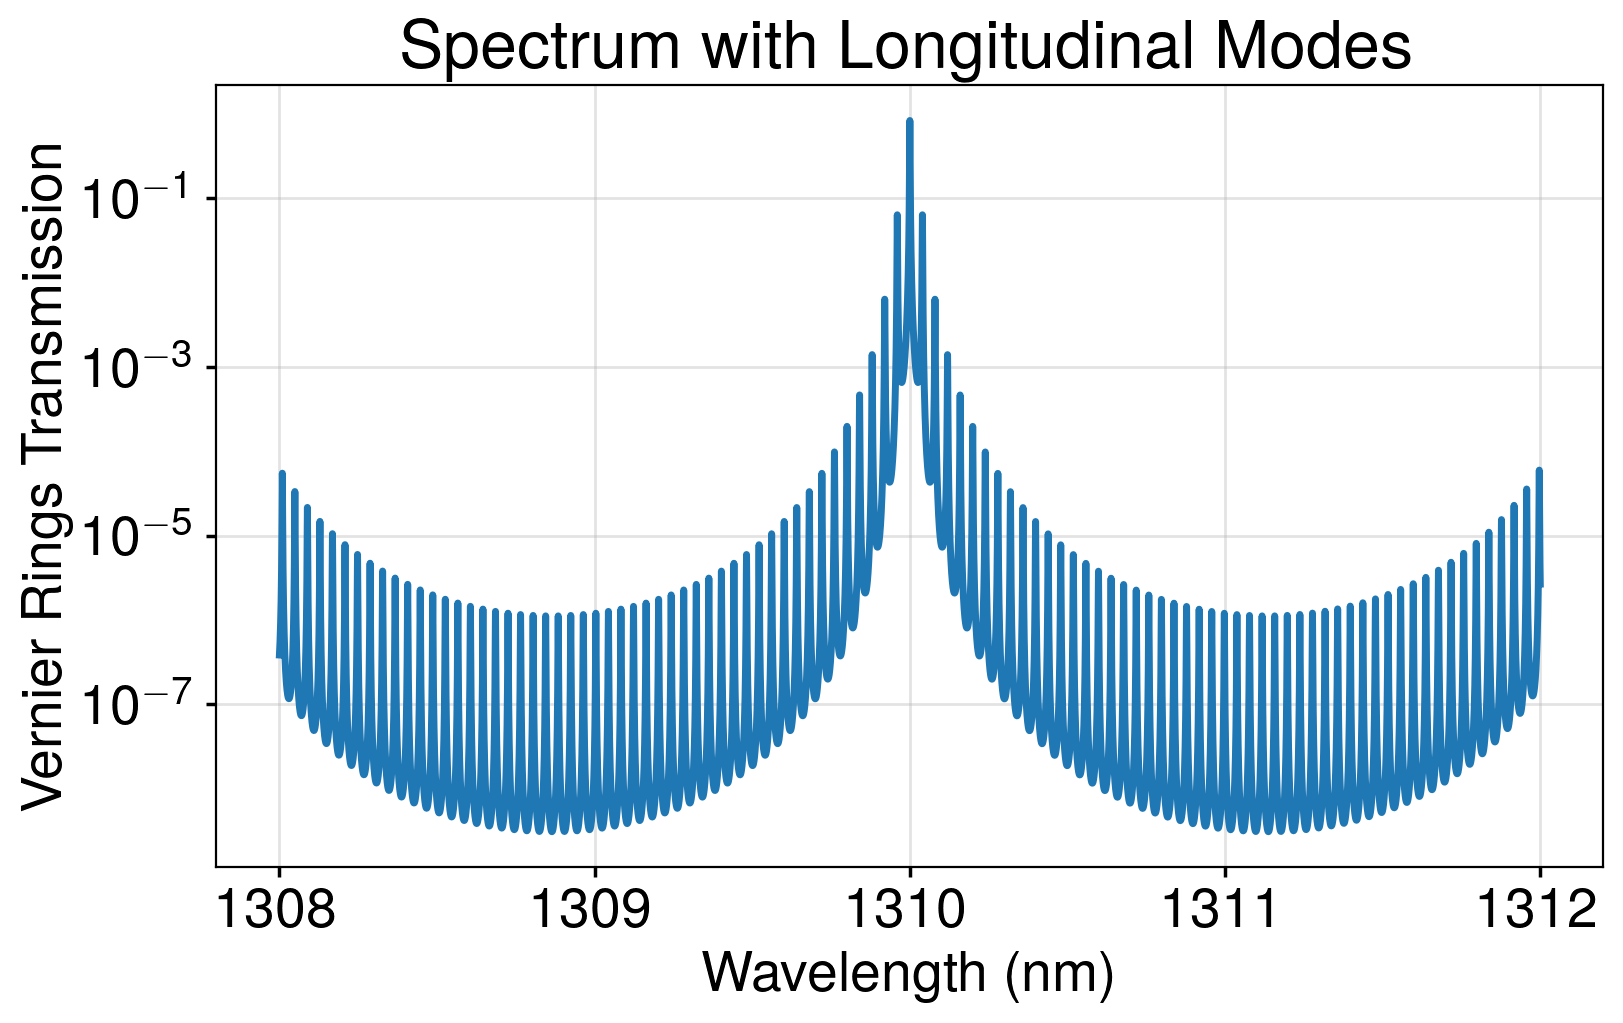

Loss in dB:  -0.7899209947105191
Ring Q:  26296.521176761948
Ring FSR:  2.2990387023569154e-09
Ring Finesse:  46.15016787994194
Vernier SMSR (dB):  7.827817500918704
Longitudinal SMSR (dB):  11.177866900444737


In [5]:
tmp = Vernier_rings_in_longitudinal_cavity(L_long=5e-3,kappa_squared=estimated_kappa_5mm,radius1=Ring1_radius,radius2=Ring2_radius,propagation_loss_dB_m=propagation_loss_dB_m)
num_points = 500000
wav, amp = tmp.Vernier_wavelength_sweep(lambda_start=1270e-9,lambda_stop=1350e-9,num=num_points)
plt.figure()
plt.semilogy(wav*1e9,amp)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Vernier Rings Transmission")
plt.title("Spectrum of Just Vernier Rings")
plt.show()

wav, amp = tmp.Vernier_with_longitudinal_wavelength_sweep(lambda_start=1270e-9,lambda_stop=1350e-9,num=num_points)
plt.figure()
plt.semilogy(wav*1e9,amp)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Vernier Rings Transmission")
plt.title("Spectrum with Longitudinal Modes")
plt.show()

wav, amp = tmp.Vernier_with_longitudinal_wavelength_sweep(lambda_start=1308e-9,lambda_stop=1312e-9,num=num_points)
plt.figure()
plt.semilogy(wav*1e9,amp)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Vernier Rings Transmission")
plt.title("Spectrum with Longitudinal Modes")
plt.show()

print("Loss in dB: ", 10*np.log10(np.max(amp)))

print("Ring Q: ",tmp.ring1.Q())
print("Ring FSR: ",tmp.ring1.FSR())
print("Ring Finesse: ",tmp.ring1.Finesse())
print("Vernier SMSR (dB): ", 10*np.log10(tmp.Vernier_SMSR()))
print("Longitudinal SMSR (dB): ", 10*np.log10(tmp.Longitudinal_SMSR()))

# 6mm Longitudinal Vernier Ring Mirror design

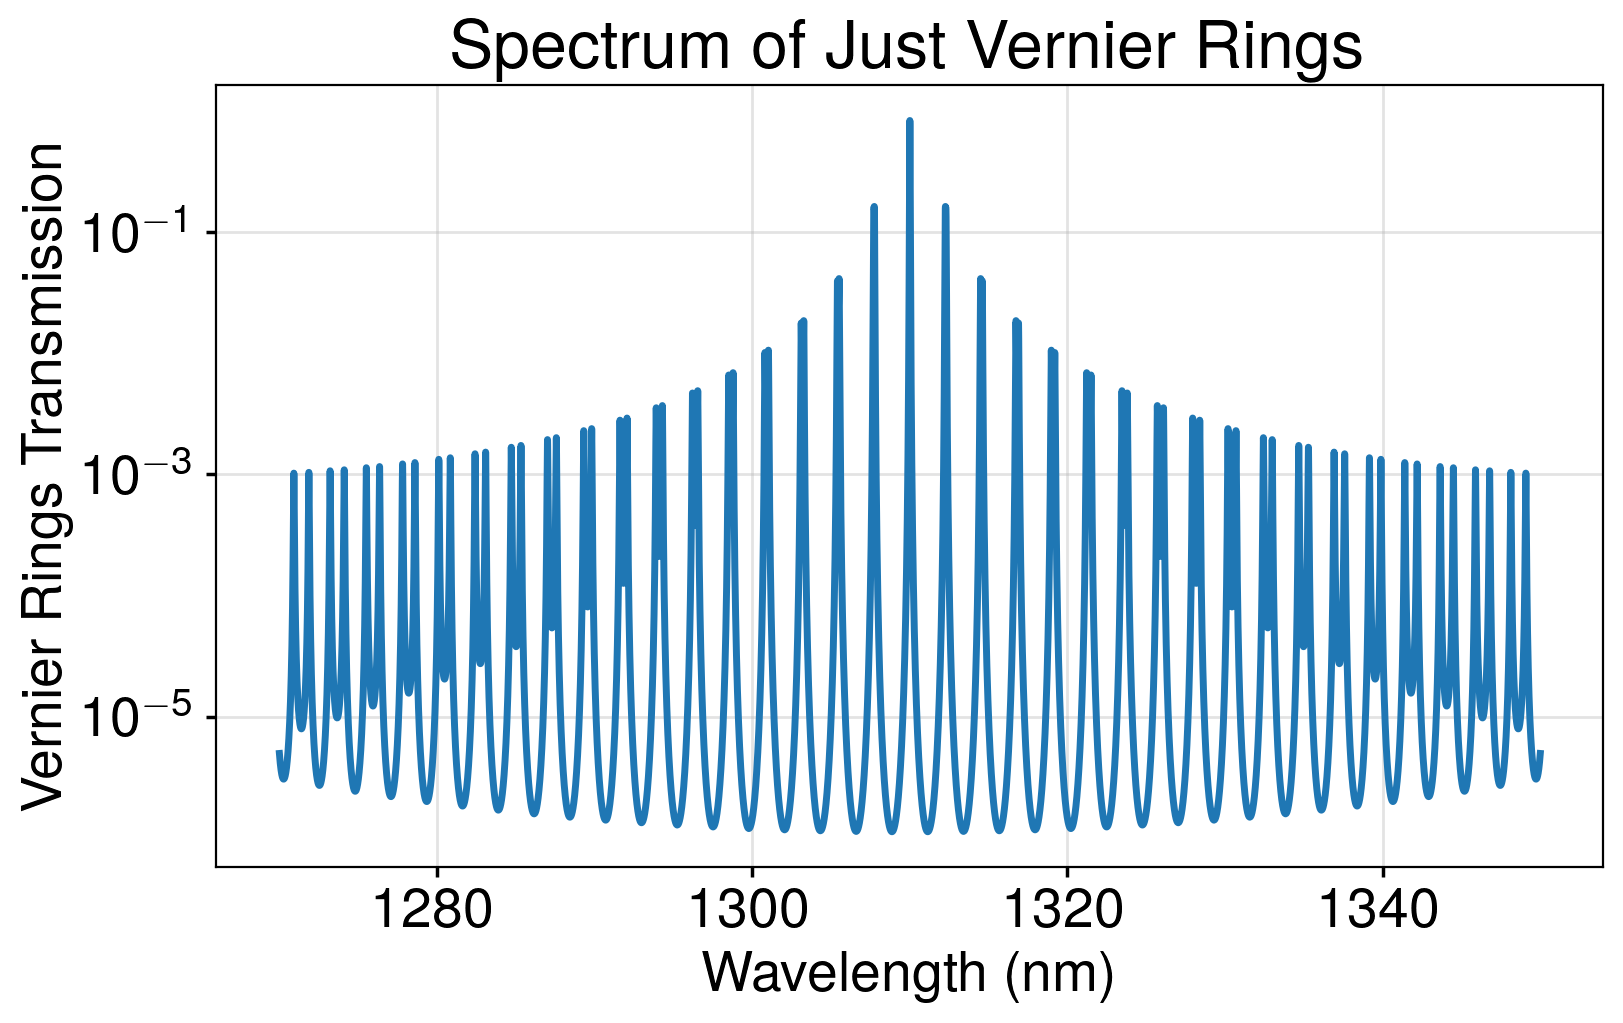

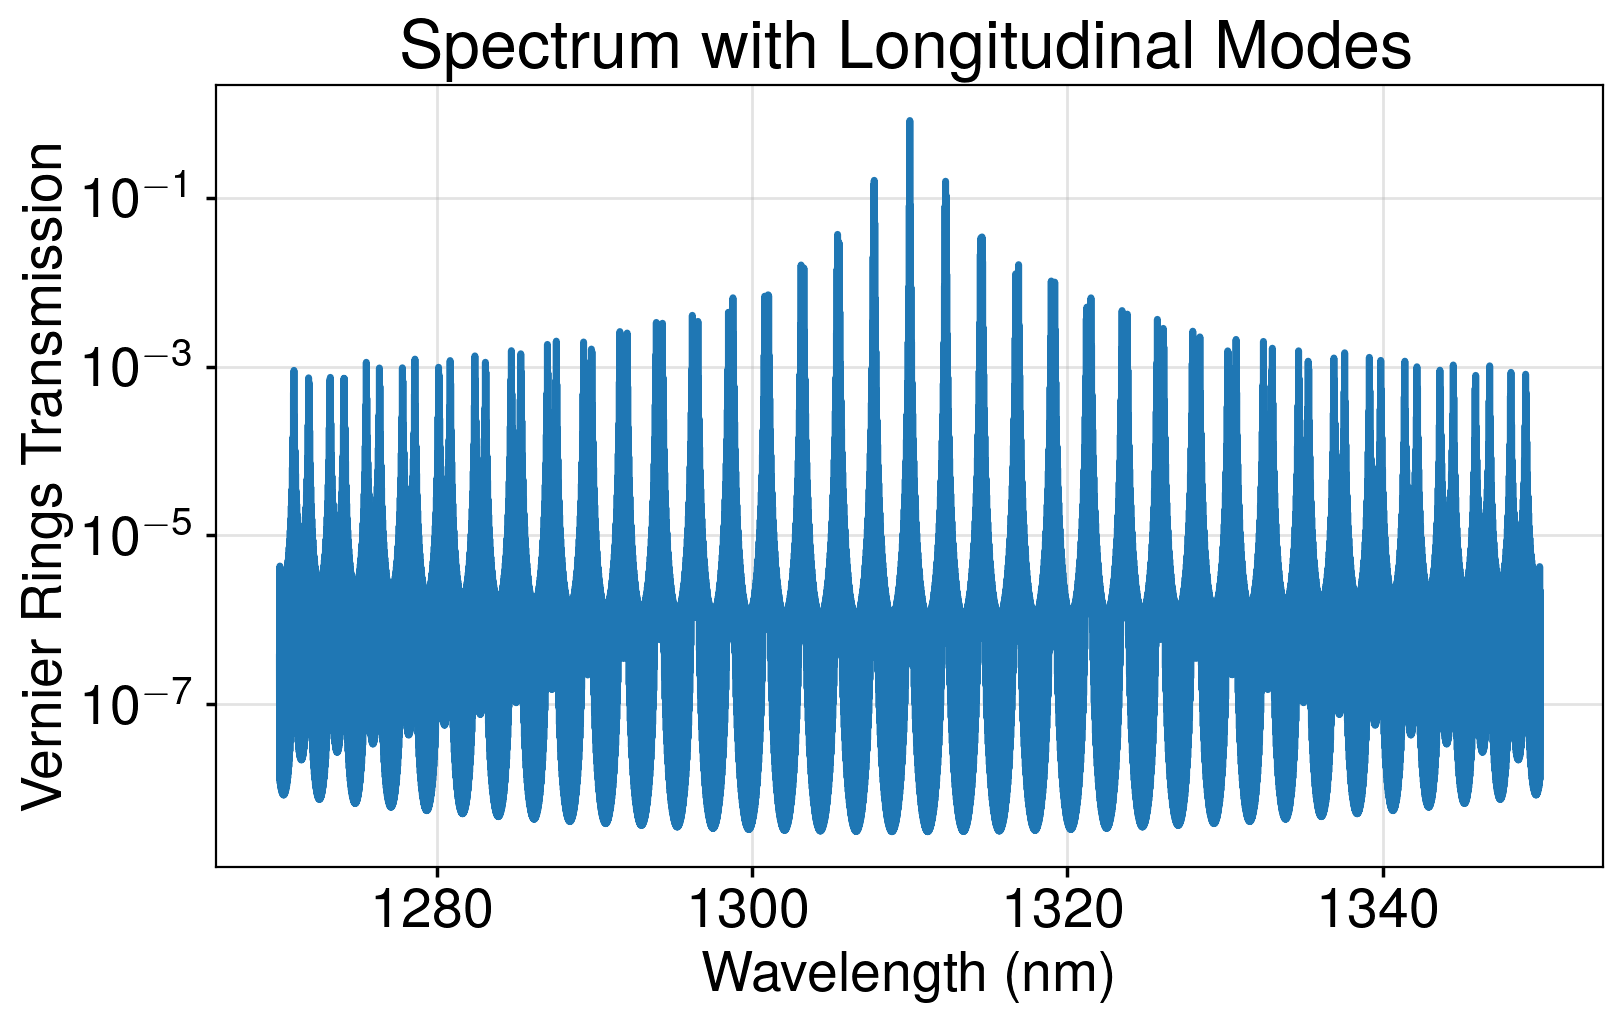

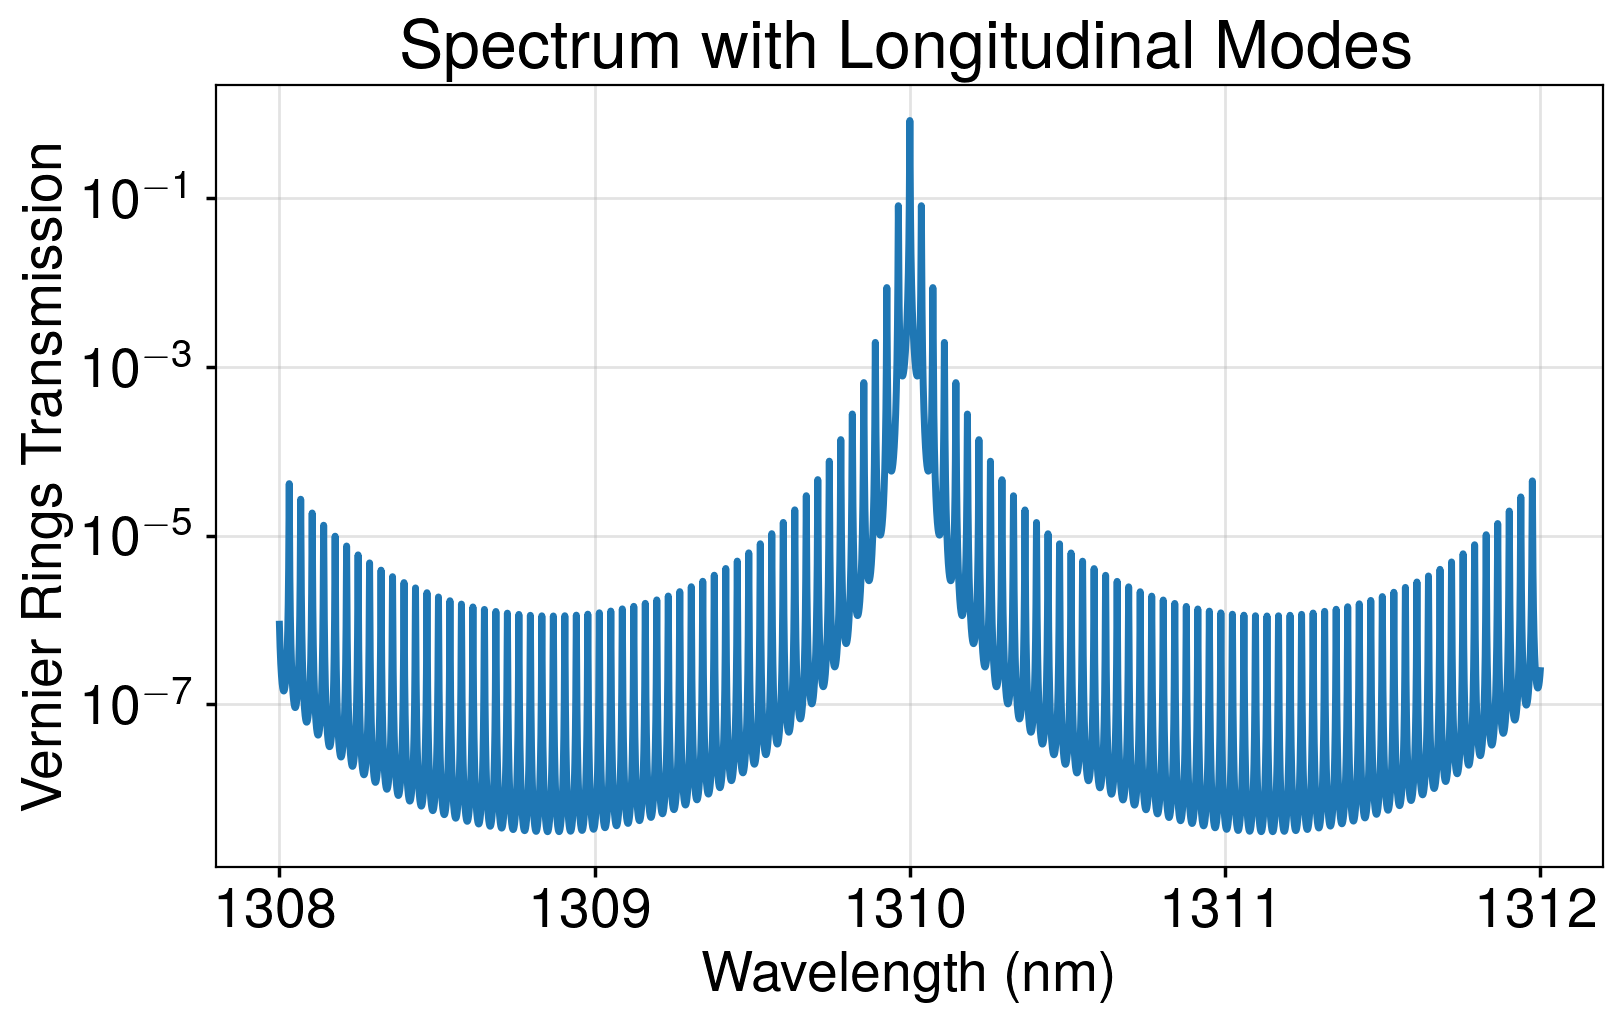

Loss in dB:  -0.7899508834764986
Ring Q:  26296.521176761948
Ring FSR:  2.2990387023569154e-09
Ring Finesse:  46.15016787994194
Vernier SMSR (dB):  7.827817500918704
Longitudinal SMSR (dB):  10.09960466333537


In [6]:
tmp = Vernier_rings_in_longitudinal_cavity(L_long=6e-3,kappa_squared=estimated_kappa_6mm,radius1=Ring1_radius,radius2=Ring2_radius,propagation_loss_dB_m=propagation_loss_dB_m)
num_points = 500000
wav, amp = tmp.Vernier_wavelength_sweep(lambda_start=1270e-9,lambda_stop=1350e-9,num=num_points)
plt.figure()
plt.semilogy(wav*1e9,amp)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Vernier Rings Transmission")
plt.title("Spectrum of Just Vernier Rings")
plt.show()

wav, amp = tmp.Vernier_with_longitudinal_wavelength_sweep(lambda_start=1270e-9,lambda_stop=1350e-9,num=num_points)
plt.figure()
plt.semilogy(wav*1e9,amp)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Vernier Rings Transmission")
plt.title("Spectrum with Longitudinal Modes")
plt.show()

wav, amp = tmp.Vernier_with_longitudinal_wavelength_sweep(lambda_start=1308e-9,lambda_stop=1312e-9,num=num_points)
plt.figure()
plt.semilogy(wav*1e9,amp)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Vernier Rings Transmission")
plt.title("Spectrum with Longitudinal Modes")
plt.show()

print("Loss in dB: ", 10*np.log10(np.max(amp)))

print("Ring Q: ",tmp.ring1.Q())
print("Ring FSR: ",tmp.ring1.FSR())
print("Ring Finesse: ",tmp.ring1.Finesse())
print("Vernier SMSR (dB): ", 10*np.log10(tmp.Vernier_SMSR()))
print("Longitudinal SMSR (dB): ", 10*np.log10(tmp.Longitudinal_SMSR()))